# üß™ Data Profiling Assignment: Getting Hands-On with Real-World Stats

Welcome! This assignment is designed to help you **play with data like working analysts do**. You‚Äôll explore a synthetic dataset with **thousands of points** and analyze it using:

- **Central tendency**: mean, median, (estimated) mode
- **Dispersion**: variance, standard deviation, coefficient of variation (CV), range, IQR
- **Shape**: skewness, kurtosis
- **Position & extremes**: min, max, percentiles, z-scores
- **Distribution rules**: Empirical Rule (68‚Äì95‚Äì99.7) & Chebyshev‚Äôs inequality

Each question asks you to **use the sample data** to compute something and **explain what it means**. After every question you‚Äôll find **two blank cells**: one for code, one for your interpretation.

**Tip:** In professional work, the numbers are just the start‚Äî**the story** they tell is what matters. Be explicit about assumptions, limitations, and what a stakeholder should take away.

## 1) Setup

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

np.set_printoptions(edgeitems=3, linewidth=120)
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 20)


## 2) Generate a Sample Dataset (thousands of points)

In [2]:
# Reproducible synthetic data that mimics different real-world shapes
rng = np.random.default_rng(42)
n = 5000  # thousands of points

# Distributions
normal = rng.normal(0, 1, n)  # symmetric, light tails
lognormal = rng.lognormal(mean=0.0, sigma=0.9, size=n)  # positive, right-skewed
t_df3 = rng.standard_t(df=3, size=n)  # symmetric, heavy tails
uniform = rng.uniform(-3, 3, size=n)  # flat
exponential = rng.exponential(scale=1.0, size=n)  # positive, right-skewed

# Bimodal mixture
bimodal = np.concatenate([
    rng.normal(-2.0, 0.5, n // 2),
    rng.normal( 2.0, 0.5, n - n // 2)
])

# Normal with a few extreme outliers injected
with_outliers = rng.normal(0, 1, n)
out_idx = rng.choice(n, size=12, replace=False)
with_outliers[out_idx] = rng.normal(0, 1, size=12) * 10

df = pd.DataFrame({
    'normal': normal,
    'lognormal': lognormal,
    't_df3': t_df3,
    'uniform': uniform,
    'exponential': exponential,
    'bimodal': bimodal,
    'with_outliers': with_outliers,
})

df.head()

normal  lognormal     t_df3   uniform  exponential   bimodal  with_outliers
0  0.304717   0.792822  0.138433 -0.045096     2.049361 -2.145103      -0.651898
1 -1.039984   0.763733 -0.229852  2.703969     1.891653 -1.722417      -1.579549
2  0.750451   0.534195  4.519477  1.059963     2.327707 -2.224025       0.646698
3  0.940565   1.470547  0.611817  0.513368     1.365464 -2.376502      -0.319862
4 -1.951035   1.235137  0.332825 -1.044643     0.389808 -2.328547      -1.262942

### Quick peek

In [3]:
df.describe().T

count      mean       std        min       25%       50%       75%        max
normal         5000.0 -0.019877  0.999454  -3.648413 -0.691954 -0.004161  0.631247   3.454046
lognormal      5000.0  1.515106  1.746572   0.019251  0.551296  0.982112  1.831378  37.458799
t_df3          5000.0  0.028603  1.652612 -12.577299 -0.742290  0.010486  0.765586  30.190838
uniform        5000.0  0.038330  1.719777  -2.999717 -1.448413  0.029373  1.530037   2.999743
exponential    5000.0  0.995986  0.993266   0.000030  0.278624  0.696891  1.374293   7.766503
bimodal        5000.0 -0.011055  2.053284  -3.798815 -2.000615  0.003059  1.972950   4.163460
with_outliers  5000.0  0.013223  1.130575  -5.917001 -0.667940 -0.001768  0.673869  20.732260

> Optional: Save a copy as CSV so you (or a teammate) can reuse the same snapshot later.

In [4]:
df.to_csv('sample_data.csv', index=False)
print('Saved sample_data.csv')

Saved sample_data.csv


## 3) Helper Utilities (optional)

In [15]:
def coefficient_of_variation(x: pd.Series):
    """CV = sample std / mean. Not meaningful when mean‚âà0 or for variables taking negative values.
    Returns np.nan if mean is too close to zero.
    """
    m = x.mean()
    s = x.std(ddof=1)
    return np.nan if np.isclose(m, 0.0) else s / m

def empirical_within_k(x: pd.Series, k: int):
    m, s = x.mean(), x.std(ddof=1)
    if np.isclose(s, 0.0):
        return np.nan
    z = (x - m) / s
    return (np.abs(z) <= k).mean()

def chebyshev_lower_bound(k: int):
    assert k >= 1
    return 1 - 1 / (k**2)

def z_scores(x: pd.Series):
    return (x - x.mean()) / x.std(ddof=1)

def hist_and_qq(x: pd.Series, bins=50, title=''):
    """Simple visuals to reason about shape (run when needed)."""
    plt.figure()
    plt.hist(x.values, bins=bins)
    plt.title(f'Histogram: {title}')
    plt.xlabel('value'); plt.ylabel('count')
    plt.show()

    # Q-Q plot against normal to assess normality / tails
    plt.figure()
    stats.probplot(x, dist='norm', plot=plt)
    plt.title(f'Normal Q-Q: {title}')
    plt.show()

# Section A ‚Äî Central Tendency

### A1. Mean vs Median (and an estimate of Mode)

Pick **two columns**‚Äîone roughly symmetric (e.g., `normal`) and one skewed (e.g., `lognormal` or `exponential`).

1) Compute the **mean** and **median** for each.
2) Provide a **rough estimate of the mode** (e.g., from the mid-point of the most populated histogram bin).
3) Explain the **ordering** you see (mean vs median vs mode) and what it implies about **symmetry/skewness**.
4) In a business context, when would you prefer **median** over **mean**, and why?

normal_mean:  -0.019877039492199437 normal_median:  -0.004160998936368686 exponential_mean:  0.9959860180487035 exponential_median:  0.6968909248280803


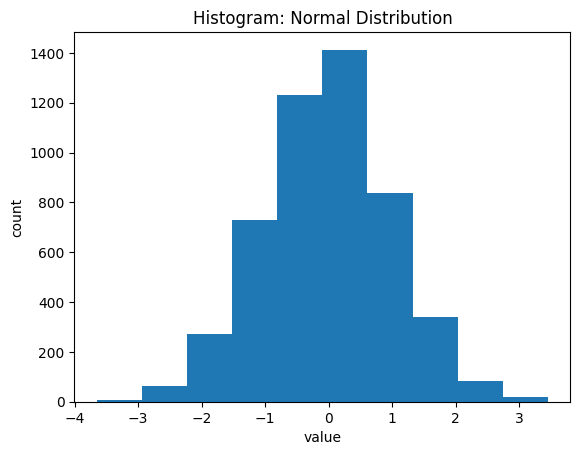

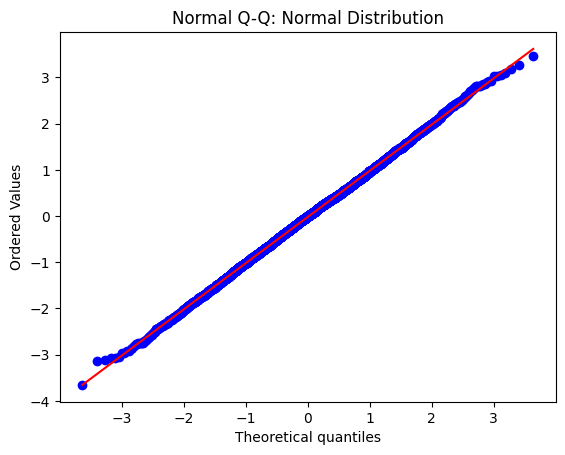

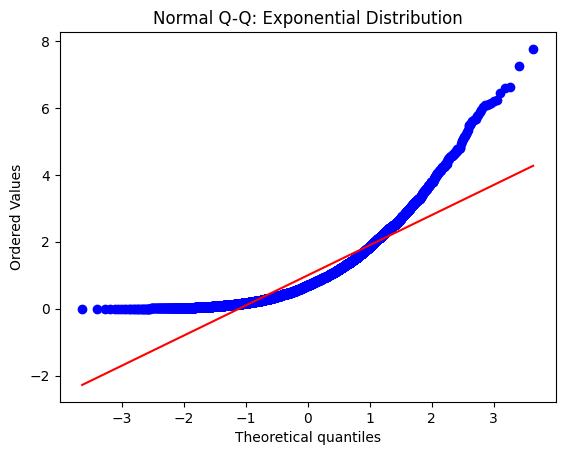

In [ ]:
# Your code here
normal_mean = df['normal'].mean()
normal_median = df['normal'].median()
exponential_mean = df['exponential'].mean()
exponential_median = df['exponential'].median()
print('normal_mean: ', normal_mean, 'normal_median: ', normal_median, 'exponential_mean: ', exponential_mean, 'exponential_median: ', exponential_median)

hist_and_qq(df['normal'], bins=10, title='Normal Distribution')
hist_and_qq(df['exponential'], bins=10, title='Exponential Distribution') #positive skewed


_Use this cell for your interpretation/short write-up._

In Normal Distribution, Mean = Median = Mode
Exponential Distribution is Positive skewed. In Positive Skewness, the right tail is much longer due to which the mean gets shifted to right. Median is the middle value and Mode is where the peak is as that is where the value with largest frequency lies.
Here, Mode < Median < Mean

Mean gets affected by outliers and hence, wherever there are outliers we prefer median over mean.

### A2. Robustness to Outliers

Using the `with_outliers` column:

1) Compute the mean and median **before** and **after** trimming the top/bottom 1% (use percentiles).
2) Which statistic is **more robust** to the injected extremes? Explain.
3) Why might stakeholders be misled by the mean here? Provide a short note.

In [25]:
# Your code here
outlier_mean = df['with_outliers'].mean()
outlier_median = df['with_outliers'].median()

#trimming
top1 = np.percentile(df['with_outliers'],99)
bottom1 = np.percentile(df['with_outliers'],1)
print('top 1%: ', top1 , 'bottom 1%: ', bottom1)

trimmed_outlier = df['with_outliers'][(df['with_outliers'] >= bottom1) & (df['with_outliers'] <= top1)]

trimmed_outlier_mean = trimmed_outlier.mean()
trimmed_outlier_median = trimmed_outlier.median()

print('outlier_mean: ', outlier_mean, 'outlier_median: ', outlier_median, 'trimmed_outlier_mean: ', trimmed_outlier_mean, 'trimmed_outlier_median: ', trimmed_outlier_median)


top 1%:  2.322361128634335 bottom 1%:  -2.4284958235790417
outlier_mean:  0.013222984100919735 outlier_median:  -0.0017684554070849642 trimmed_outlier_mean:  0.0007143912742874271 trimmed_outlier_median:  -0.0017684554070849642


_Use this cell for your interpretation/short write-up._

As we can see in the reults, the mean before trimming and after trimming has varied by a lot whereas median stays the same. This shows, how mean is affected by extreme values and how median is much more robust towards outliers. This is the very reason that mean can be a bit misleading.


# Section B ‚Äî Dispersion (Spread)

### B1. Variance, Standard Deviation, Range, and IQR

For **at least three columns** (suggestion: `normal`, `t_df3`, `with_outliers`):

1) Compute **variance**, **standard deviation**, **range** (max‚àímin), and **IQR** (Q3‚àíQ1).
2) Interpret how **outliers** and **heavy tails** change these measures.
3) Who would care about this in practice (e.g., risk teams, operations, product)?

In [ ]:
# Your code here
normal_var = df['normal'].var()
normal_std = df['normal'].std()
normal_range = df['normal'].max() - df['normal'].min() 
normal_IQR = np.percentile(df['normal'],75) - np.percentile(df['normal'],25)
t_df3_var = df['t_df3'].var()
t_df3_std = df['t_df3'].std()
t_df3_range = df['t_df3'].max() - df['t_df3'].min() 
t_df3_IQR = np.percentile(df['t_df3'],75) - np.percentile(df['t_df3'],25)
outliers_var = df['with_outliers'].var()
outliers_std = df['with_outliers'].std()
outliers_range = df['with_outliers'].max() - df['with_outliers'].min() 
outliers_IQR = np.percentile(df['with_outliers'],75) - np.percentile(df['with_outliers'],25)

print('normal_var: ',normal_var, 'normal_std: ',normal_std, 'normal_range: ', normal_range, 'normal_IQR: ', normal_IQR,'t_df3_var: ', t_df3_var, 't_df3_std: ', t_df3_std, 't_df3_range: ', t_df3_range, 't_df3_IQR: ', t_df3_IQR,'outliers_var: ',outliers_var ,'outliers_std: ', outliers_std ,'outliers_range: ', outliers_range , 'outliers_IQR: ',outliers_IQR )



normal_var:  0.9989092424253186 normal_std:  0.999454472412485 normal_range:  7.102459227458965 normal_IQR:  1.3232014380197659 t_df3_var:  2.731127149983795 t_df3_std:  1.652612220087881 t_df3_range:  42.76813664678142 t_df3_IQR:  1.5078760641179785 outliers_var:  1.2781993004481174 outliers_std:  1.1305747655277458 outliers_range:  26.649261030622817 outliers_IQR:  1.3418089963348763


_Use this cell for your interpretation/short write-up._

### B2. Coefficient of Variation (CV)

For **positive-valued** columns (e.g., `lognormal`, `exponential`):

1) Compute **CV = std/mean**.
2) Rank the selected columns by CV.
3) Explain when CV is **not appropriate** (hint: mean‚âà0 or sign changes).

In [29]:
# Your code here
log_cv = coefficient_of_variation(df['lognormal'])
exp_cv = coefficient_of_variation(df['exponential'])
print('lognormal cv:', log_cv, 'exponential cv:', exp_cv)

lognormal cv: 1.1527715402619247 exponential cv: 0.9972686042945244


_Use this cell for your interpretation/short write-up._

exponential cv is better as lesser cv means the spread of data is less - less outliers, whereas in lognormal distribution the spread is more - more outliers

if mean =0, cv = infinite - this tells nothing about the data. sd is always positive, if cv is negative then it is because of mean. sign can be ignored as it doesn't tells us anything except that mean is negative, over here.

# Section C ‚Äî Shape of the Distribution

### C1. Skewness & Kurtosis

Across **all columns**:

1) Compute **skewness** and **(excess) kurtosis** (use `scipy.stats.skew` and `scipy.stats.kurtosis(fisher=True)`).
2) Identify which distributions are **right/left-skewed**.
3) Which have **heavy tails** (excess kurtosis > 0)? How does that show up in the Q-Q plot?

normal_skew:  0.0021419231638830417 normal_kurtosis:  0.03616019787656244 bimodal_skew:  0.0034960490619891627 bimodal_kurtosis:  -1.7645711932497226 exponential_skew:  1.8646619760514398 exponential_kurtosis:  4.6052724028588115 lognormal_skew:  5.130449440730955 lognormal_kurtosis:  56.696522534747125 t_df3_skew:  1.5443974749085707 t_df3_kurtosis:  31.241593839780577 uniform_skew:  -0.02368703193019682 uniform_kurtosis:  -1.1863366167483336 with_outliers_skew:  2.9747569775870435 with_outliers_kurtosis:  46.33141735598613


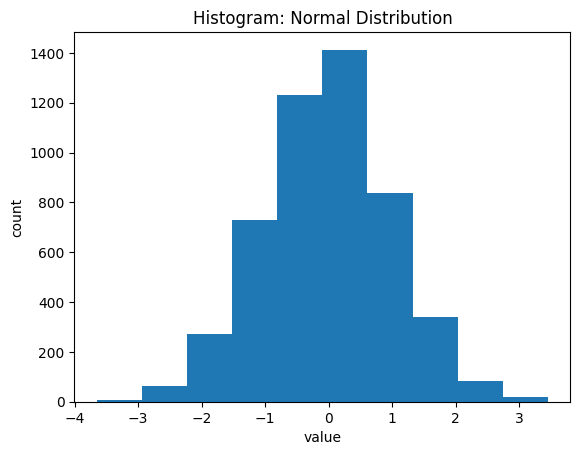

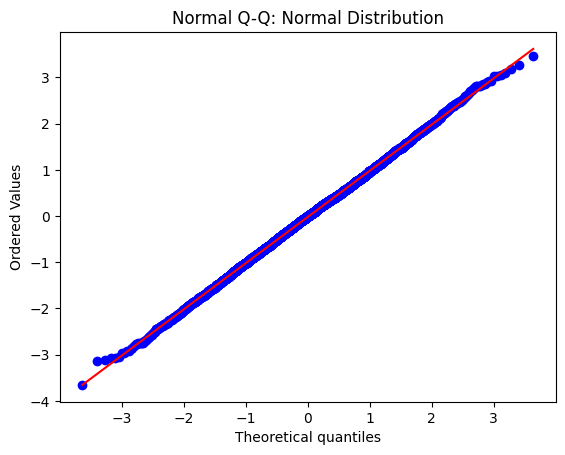

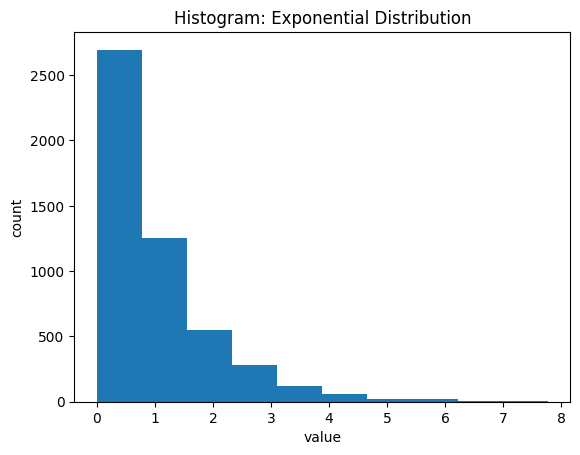

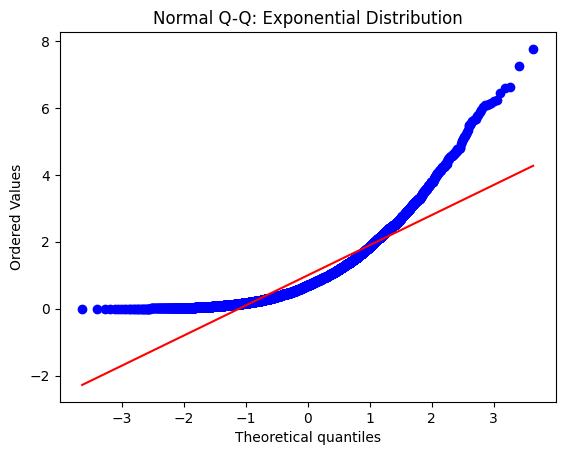

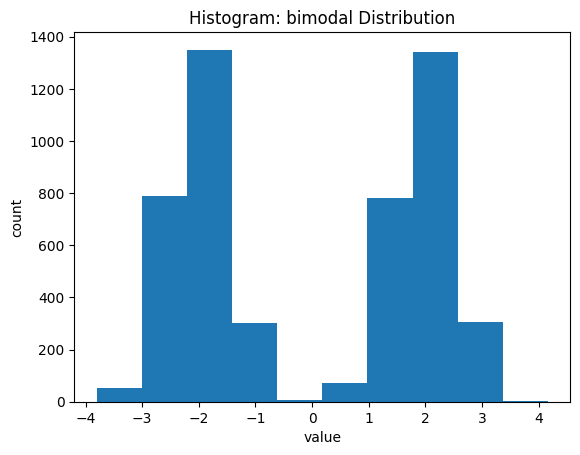

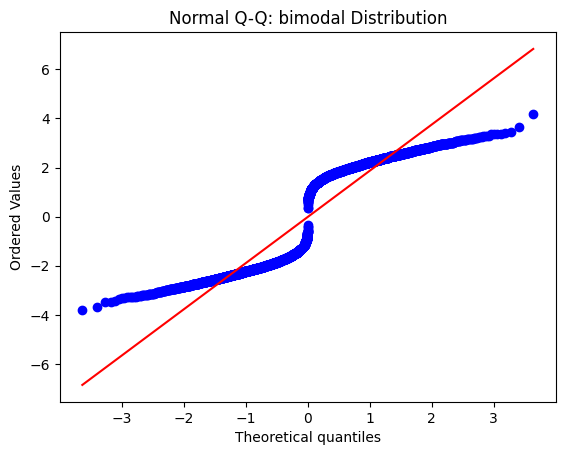

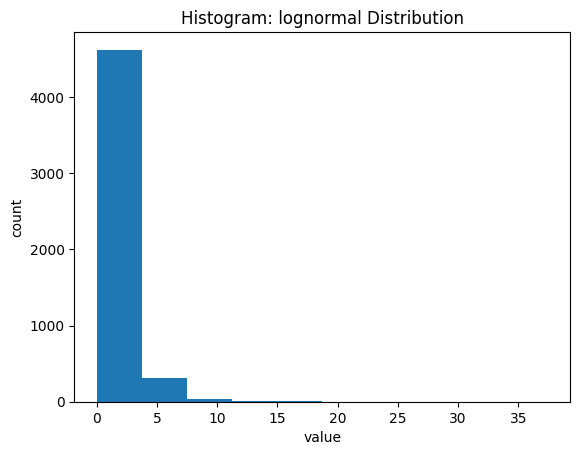

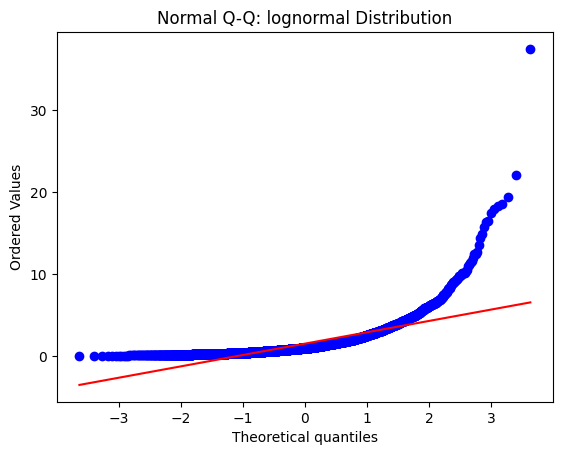

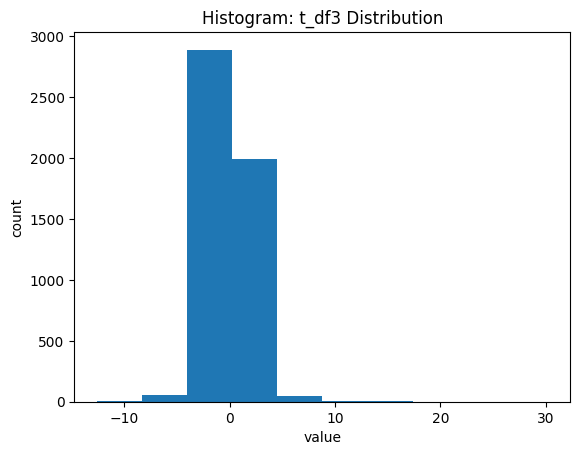

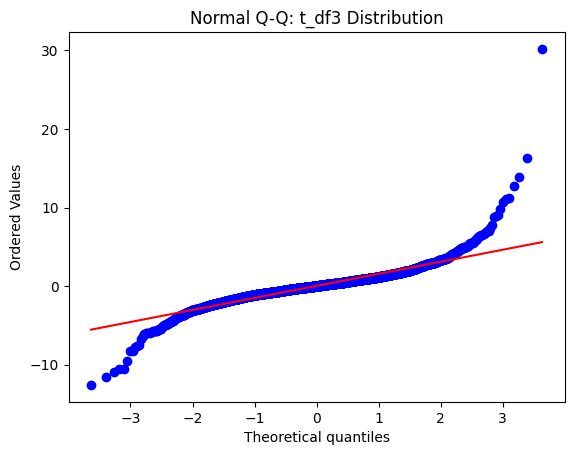

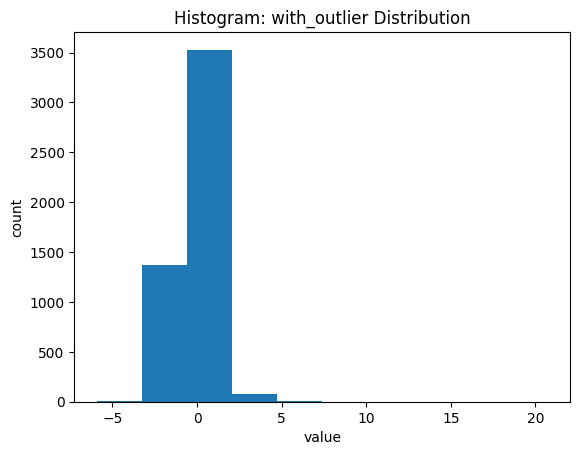

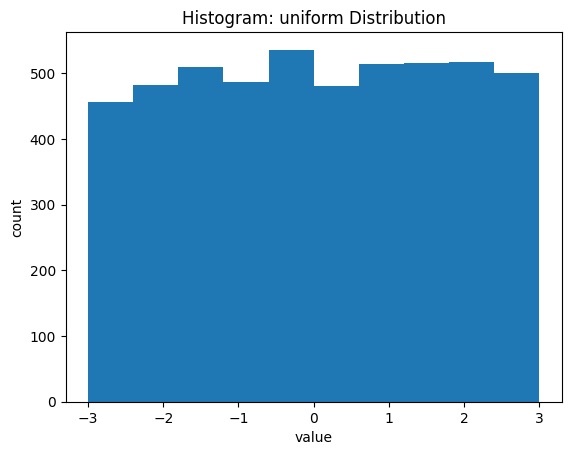

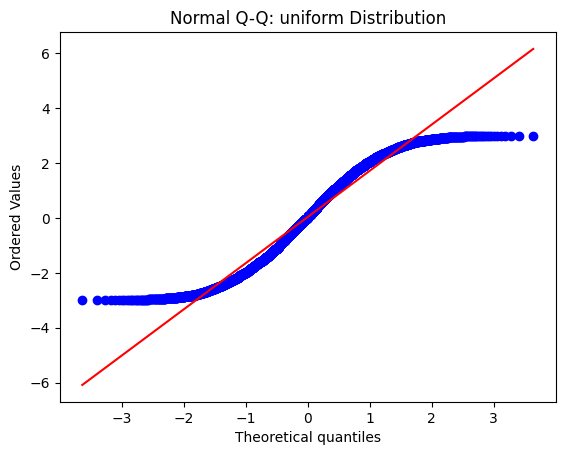

In [37]:
# Your code here
from scipy.stats import skew, kurtosis
normal_skew = skew(df['normal'])
normal_kurtosis = kurtosis(df['normal'], fisher = True)
bimodal_skew = skew(df['bimodal'])
bimodal_kurtosis = kurtosis(df['bimodal'], fisher = True)
exponential_skew = skew(df['exponential'])
exponential_kurtosis = kurtosis(df['exponential'], fisher = True)
lognormal_skew = skew(df['lognormal'])
lognormal_kurtosis = kurtosis(df['lognormal'], fisher = True)
t_df3_skew = skew(df['t_df3'])
t_df3_kurtosis = kurtosis(df['t_df3'], fisher = True)
uniform_skew = skew(df['uniform'])
uniform_kurtosis = kurtosis(df['uniform'], fisher = True)
with_outliers_skew = skew(df['with_outliers'])
with_outliers_kurtosis = kurtosis(df['with_outliers'], fisher = True)



print('normal_skew: ', normal_skew, 'normal_kurtosis: ', normal_kurtosis, 'bimodal_skew: ', bimodal_skew, 'bimodal_kurtosis: ', bimodal_kurtosis, 'exponential_skew: ', 
      exponential_skew, 'exponential_kurtosis: ', exponential_kurtosis, 'lognormal_skew: ', lognormal_skew, 'lognormal_kurtosis: ', lognormal_kurtosis, 
      't_df3_skew: ', t_df3_skew, 't_df3_kurtosis: ', t_df3_kurtosis, 'uniform_skew: ', uniform_skew, 'uniform_kurtosis: ', uniform_kurtosis, 
      'with_outliers_skew: ', with_outliers_skew, 'with_outliers_kurtosis: ', with_outliers_kurtosis)

hist_and_qq(df['normal'], bins=10, title='Normal Distribution')
hist_and_qq(df['exponential'], bins=10, title='Exponential Distribution')
hist_and_qq(df['bimodal'], bins=10, title='bimodal Distribution')
hist_and_qq(df['lognormal'], bins=10, title='lognormal Distribution')
hist_and_qq(df['t_df3'], bins=10, title='t_df3 Distribution')
hist_and_qq(df['with_outliers'], bins=10, title='with_outlier Distribution')
hist_and_qq(df['uniform'], bins=10, title='uniform Distribution')

_Use this cell for your interpretation/short write-up._

If skewness is positive then it is right skewed, if negative then it is left skewed, if zero then it's normal distribution.
Right Skewed - bimodal, exponential, lognormal, t_df3, with_outlier
Left Skewed - unifrom
Zero Skewness - normal (a little right skewed)

fisher gives us excess kurtosis, if 0 then it's normal, > 0 heavy tail and < 0 light tail
heavy tail - exponential, lognormal, t_df3, with_outlier

In the QQ plot, the red line shows normal distribution. The heaviness of tail can be interpreted looking at the overlap between red line and blue curve.

### C2. Visual Intuition Check

Pick **two columns** with different shapes (e.g., `normal` vs `bimodal`).

1) Plot a histogram and a normal Q-Q plot for each (use `hist_and_qq`).
2) Explain **why** percentiles or averages alone can miss **multimodality**.

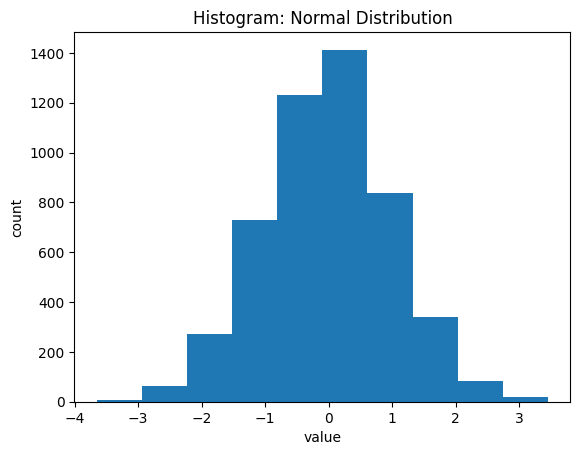

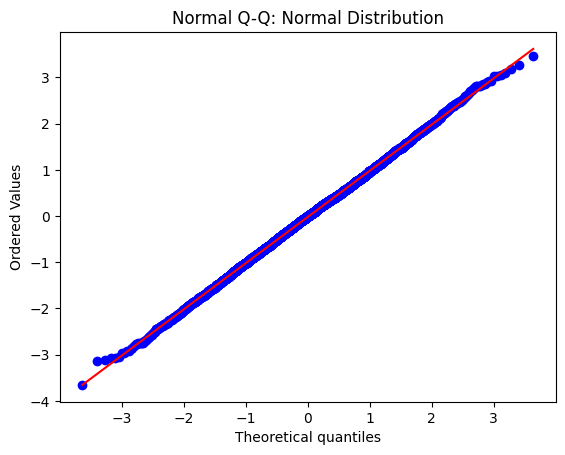

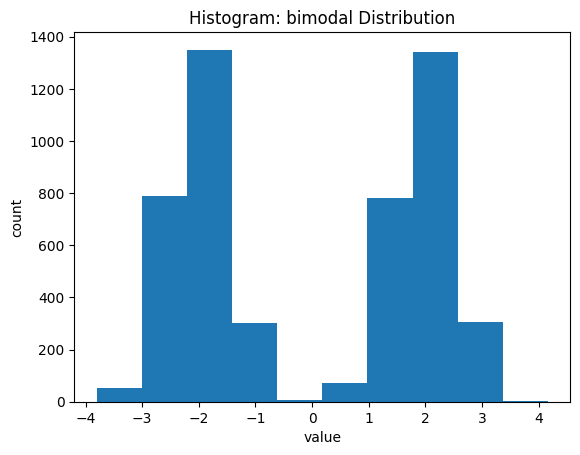

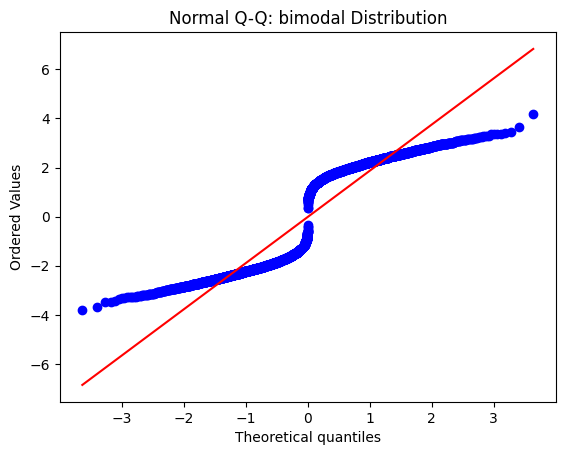

In [39]:
# Your code here
hist_and_qq(df['normal'], bins=10, title='Normal Distribution')
hist_and_qq(df['bimodal'], bins=10, title='bimodal Distribution')

_Use this cell for your interpretation/short write-up._

mean and percentile doesn't give any description of the shape.
(used chatgpt)
eg - normal distribution at 0 and bimodal with peaks -2 and 2, have same mean.
percentile gives overview at a particluar point, it might show some gaps but it doesn't prove multimodality in anyway.

# Section D ‚Äî Position & Extremes

### D1. Min/Max & Percentiles

For **each column**:

1) Report **min**, **max**, and key **percentiles** (1st, 5th, 25th, 50th, 75th, 95th, 99th).
2) Which columns show the **widest spread** between the 1st and 99th percentiles?
3) What operational risks might that imply?

In [45]:
# Your code here
normal_min = df['normal'].min()
normal_max = df['normal'].max()
bimodal_min = df['bimodal'].min()
bimodal_max = df['bimodal'].max()
uniform_min = df['uniform'].min()
uniform_max = df['uniform'].max()
exponential_min = df['exponential'].min()
exponential_max = df['exponential'].max()
t_df3_min = df['t_df3'].min()
t_df3_max = df['t_df3'].max()
outlier_min = df['with_outliers'].min()
outlier_max = df['with_outliers'].max()
lognormal_min = df['lognormal'].min()
lognormal_max = df['lognormal'].max()

normal_p1 = np.percentile(df['normal'], 1)
normal_p5 = np.percentile(df['normal'], 5)
normal_p25 = np.percentile(df['normal'], 25)
normal_p50 = np.percentile(df['normal'], 50)
normal_p75 = np.percentile(df['normal'], 75)
normal_p95 = np.percentile(df['normal'], 95)
normal_p99 = np.percentile(df['normal'], 99)
normal_spread = normal_p99-normal_p1

bimodal_p1 = np.percentile(df['bimodal'], 1)
bimodal_p5 = np.percentile(df['bimodal'], 5)
bimodal_p25 = np.percentile(df['bimodal'], 25)
bimodal_p50 = np.percentile(df['bimodal'], 50)
bimodal_p75 = np.percentile(df['bimodal'], 75)
bimodal_p95 = np.percentile(df['bimodal'], 95)
bimodal_p99 = np.percentile(df['bimodal'], 99)
bimodal_spread = bimodal_p99-bimodal_p1

exponential_p1 = np.percentile(df['exponential'], 1)
exponential_p5 = np.percentile(df['exponential'], 5)
exponential_p25 = np.percentile(df['exponential'], 25)
exponential_p50 = np.percentile(df['exponential'], 50)
exponential_p75 = np.percentile(df['exponential'], 75)
exponential_p95 = np.percentile(df['exponential'], 95)
exponential_p99 = np.percentile(df['exponential'], 99)
exponential_spread = exponential_p99-exponential_p1

lognormal_p1 = np.percentile(df['lognormal'], 1)
lognormal_p5 = np.percentile(df['lognormal'], 5)
lognormal_p25 = np.percentile(df['lognormal'], 25)
lognormal_p50 = np.percentile(df['lognormal'], 50)
lognormal_p75 = np.percentile(df['lognormal'], 75)
lognormal_p95 = np.percentile(df['lognormal'], 95)
lognormal_p99 = np.percentile(df['lognormal'], 99)
lognormal_spread = lognormal_p99-lognormal_p1

uniform_p1 = np.percentile(df['uniform'], 1)
uniform_p5 = np.percentile(df['uniform'], 5)
uniform_p25 = np.percentile(df['uniform'], 25)
uniform_p50 = np.percentile(df['uniform'], 50)
uniform_p75 = np.percentile(df['uniform'], 75)
uniform_p95 = np.percentile(df['uniform'], 95)
uniform_p99 = np.percentile(df['uniform'], 99)
uniform_spread = uniform_p99-uniform_p1

t_df3_p1 = np.percentile(df['t_df3'], 1)
t_df3_p5 = np.percentile(df['t_df3'], 5)
t_df3_p25 = np.percentile(df['t_df3'], 25)
t_df3_p50 = np.percentile(df['t_df3'], 50)
t_df3_p75 = np.percentile(df['t_df3'], 75)
t_df3_p95 = np.percentile(df['t_df3'], 95)
t_df3_p99 = np.percentile(df['t_df3'], 99)
t_df3_spread = t_df3_p99-t_df3_p1

outliers_p1 = np.percentile(df['with_outliers'], 1)
outliers_p5 = np.percentile(df['with_outliers'], 5)
outliers_p25 = np.percentile(df['with_outliers'], 25)
outliers_p50 = np.percentile(df['with_outliers'], 50)
outliers_p75 = np.percentile(df['with_outliers'], 75)
outliers_p95 = np.percentile(df['with_outliers'], 95)
outliers_p99 = np.percentile(df['with_outliers'], 99)
outliers_spread = outliers_p99-outliers_p1


print('normal_min: ', normal_min, 'normal_max: ', normal_max, 'bimodal_min: ', bimodal_min, 'bimodal_max: ', bimodal_max, 'uniform_min: ', uniform_min, 'uniform_max: ', uniform_max,
      'exponential_min: ', exponential_min, 'exponential_max: ', exponential_max, 't_df3_min: ', t_df3_min, 't_df3_max: ', t_df3_max, 'outlier_min: ', outlier_min,
      'outlier_max: ', outlier_max, 'lognormal_min: ', lognormal_min, 'lognormal_max: ', lognormal_max)
print('normal_p1: ', normal_p1, 'normal_p5: ', normal_p5, 'normal_p25: ', normal_p25, 'normal_p50: ', normal_p50, 'normal_p75: ', normal_p75, 'normal_p95: ', normal_p95, 'normal_p99: ', normal_p99,
      'bimodal_p1: ', bimodal_p1, 'bimodal_p5: ', bimodal_p5, 'bimodal_p25: ', bimodal_p25, 'bimodal_p50: ', bimodal_p50, 'bimodal_p75: ', bimodal_p75, 'bimodal_p95: ', bimodal_p95, 'bimodal_p99: ', bimodal_p99,
      'exponential_p1: ', exponential_p1, 'exponential_p5: ', exponential_p5, 'exponential_p25: ', exponential_p25, 'exponential_p50: ', exponential_p50, 'exponential_p75: ', exponential_p75, 'exponential_p95: ', exponential_p95, 'exponential_p99: ', exponential_p99,
      'lognormal_p1: ', lognormal_p1, 'lognormal_p5: ', lognormal_p5, 'lognormal_p25: ', lognormal_p25, 'lognormal_p50: ', lognormal_p50, 'lognormal_p75: ', lognormal_p75, 'lognormal_p95: ', lognormal_p95, 'lognormal_p99: ', lognormal_p99,
      'uniform_p1: ', uniform_p1, 'uniform_p5: ', uniform_p5, 'uniform_p25: ', uniform_p25, 'uniform_p50: ', uniform_p50, 'uniform_p75: ', uniform_p75, 'uniform_p95: ', uniform_p95, 'uniform_p99: ', uniform_p99,
      't_df3_p1: ', t_df3_p1, 't_df3_p5: ', t_df3_p5, 't_df3_p25: ', t_df3_p25, 't_df3_p50: ', t_df3_p50, 't_df3_p75: ', t_df3_p75, 't_df3_p95: ', t_df3_p95, 't_df3_p99: ', t_df3_p99,
      'outliers_p1: ', outliers_p1, 'outliers_p5: ', outliers_p5, 'outliers_p25: ', outliers_p25, 'outliers_p50: ', outliers_p50, 'outliers_p75: ', outliers_p75, 'outliers_p95: ', outliers_p95, 'outliers_p99: ', outliers_p99)
print('normal_spread: ', normal_spread, 'bimodal_spread:', bimodal_spread, 'exponential_spread: ', exponential_spread, 'lognormal_spread: ', lognormal_spread, 'uniform_spread: ', uniform_spread, 't_df3_spread: ', t_df3_spread, 'outliers_spread: ', outliers_spread)

normal_min:  -3.6484128252147836 normal_max:  3.4540464022441815 bimodal_min:  -3.7988153583494073 bimodal_max:  4.163460370305065 uniform_min:  -2.9997167410246712 uniform_max:  2.999742547680544 exponential_min:  2.9906181678330838e-05 exponential_max:  7.766503114840197 t_df3_min:  -12.577299053080107 t_df3_max:  30.190837593701314 outlier_min:  -5.917001451174874 outlier_max:  20.732259579447945 lognormal_min:  0.019250791034749755 lognormal_max:  37.45879910553938
normal_p1:  -2.3444747499245584 normal_p5:  -1.6865114653702984 normal_p25:  -0.691954009439011 normal_p50:  -0.004160998936368686 normal_p75:  0.6312474285807549 normal_p95:  1.6162429174935773 normal_p99:  2.3746865073530095 bimodal_p1:  -3.0266464923493293 bimodal_p5:  -2.6454370521307324 bimodal_p25:  -2.0006149837300824 bimodal_p50:  0.0030591673006615805 bimodal_p75:  1.9729502931135288 bimodal_p95:  2.635165858679973 bimodal_p99:  3.01246536973391 exponential_p1:  0.008760442599590018 exponential_p5:  0.0535532418

_Use this cell for your interpretation/short write-up._

t_df3 has the biggest spread 9.17 
If data spread is more than there are more chances of outliers

### D2. Z-Scores & Outlier Flagging

Using the `with_outliers` column:

1) Compute **z-scores** and count points with **|z| > 3**.
2) Show the **indices** (or values) of these potential outliers.
3) Explain the difference between **statistical outliers** and **bad data**.

In [ ]:
# Your code here
outliers_zscore = z_scores(df['with_outliers'])
#print('outlier_zscore: ', outliers_zscore)
count = 0
for s in range(len(outliers_zscore)):
        print(s)
        count +=1
print('zscores > 3: ',count)



85
553
688
1182
1336
1430
1719
1819
1856
2055
2502
2595
2627
3181
3185
3580
3760
3847
4345
zscores > 3:  19


_Use this cell for your interpretation/short write-up._

statistical outliers aren't wrong, these values are just rare. Whereas, bad data means the data has missing or incorrect values.

# Section E ‚Äî Distribution Rules

### E1. Empirical Rule (68‚Äì95‚Äì99.7)

For `normal` and `t_df3`:

1) Compute the **proportion of points** within **1, 2, and 3** standard deviations of the mean.
2) Compare to **68% / 95% / 99.7%**. Where does it **match or break down**, and why?
3) What decision mistakes might happen if someone assumes normality where it doesn‚Äôt hold?

In [ ]:
# Your code here

_Use this cell for your interpretation/short write-up._

### E2. Chebyshev‚Äôs Inequality (distribution-free bound)

Pick any **three columns**:

1) For **k = 2 and 3**, compute Chebyshev‚Äôs **lower bound** (‚â• 1 ‚àí 1/k¬≤) for the proportion within k SDs.
2) Compute the **actual proportions** and compare to the bounds.
3) Explain why Chebyshev‚Äôs bound can be **loose** but still **useful** in practice.

In [ ]:
# Your code here

_Use this cell for your interpretation/short write-up._

# Section F ‚Äî Synthesis & Communication

### F1. Tell the Data Story

Choose **two columns** with contrasting behavior (e.g., `lognormal` vs `t_df3`).

Write a short **executive-style note** (5‚Äì10 sentences) for a non-technical stakeholder that explains:
- Central tendency: which typical value is most representative and why
- Spread: what volatility/risk is present and how you‚Äôd summarize it
- Shape: skew/tails and what they mean for planning
- Extremes: what to expect in the worst 1‚Äì5% of cases
- Any **actionable recommendations**

In [ ]:
# Your code here

_Use this cell for your interpretation/short write-up._

---
### Submission Checklist
- Run all cells in order.
- Ensure each question has code + a short written interpretation.
- If you add extra visualizations or helper functions, briefly justify them.

Good luck & have fun exploring! üßë‚Äçüíªüìä